## TODO:

1. incorporate `PrettyDuration` into `JagularFileMap` and update `__repr__` [DONE!]
1. split out `pairwise` and `is_sorted` to `utils` [DONE!]
1. fix issue of `header_size`
1. fix test data [DONE!]
1. write actual utiity function to return data and/or list of required files
1. finish `NotImplementedError` functions
1. deal with duplicates, and overlaps
1. consider graceful abort?
1. FFB! Provide way to request specific channel(s) and provide for inter-file interpolation (default should maybe return all channels?)
1. ...?

In [1]:
import struct
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal

from scipy.signal import filtfilt, iirdesign
from numpy import memmap

import nelpy as nel
import nelpy.plotting as npl

%matplotlib inline

In [2]:
import jagular as jag

<AnalogSignalArray at 0x7fd436502a58: 1 signals (2 segments)> for a total of 6.1776 seconds


/home/etienne/Dropbox/code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


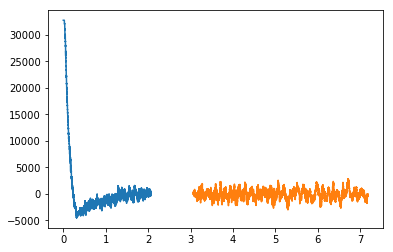

In [3]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
y = np.fromfile('channels/gap_ch.02.raw', dtype=np.int16)
sig = nel.AnalogSignalArray(ydata=y, timestamps=ts/30000, fs=30000)
print(sig)
npl.plot(sig)

<AnalogSignalArray at 0x7fd401aca080: 1 signals (2 segments)> for a total of 6.1776 seconds


/home/etienne/Dropbox/code/nelpy/nelpy/core/_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


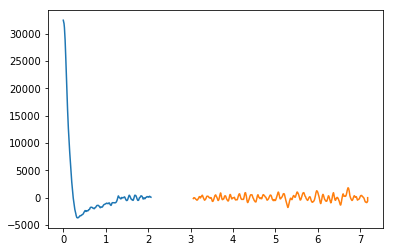

In [4]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
y = np.fromfile('filtered.raw', dtype=np.int16)
sig = nel.AnalogSignalArray(ydata=y, timestamps=ts/30000, fs=30000)
print(sig)
npl.plot(sig)

In [7]:
np.where(np.diff(ts)==0)[0]

array([69548], dtype=int64)

In [9]:
ts[69548]

99547

In [10]:
ts[69549]

99547

In [11]:
np.unique(np.diff(ts))

array([    0,     1, 30000], dtype=uint32)

In [12]:
y = memmap('channels/gap_ch.02.raw', dtype=np.uint16, mode='r')
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
jag.utils.get_contiguous_segments(ts, in_core=False, assume_sorted=True)

array([[     0,  62011],
       [ 92010,  99548],
       [ 99547, 215326]], dtype=int64)

In [13]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
epochs = jag.utils.get_contiguous_segments(ts)
epochs

d:\dropbox\code\jagular\jagular\utils.py:117: UserWarning: some steps in the data are smaller than the requested step size.


array([[      0.,   62011.],
       [  92010.,  215326.]])

In [14]:
ccl = (np.cumsum(epochs[:,1] - epochs[:,0]) - 1).astype(np.int32)
ccr = np.cumsum(epochs[:,1] - epochs[:,0]).astype(np.int32)
orig_data_locs = np.vstack((np.insert(ccr[:-1],0,0),ccr)).T
orig_data_locs

array([[     0,  62011],
       [ 62011, 185327]])

filtering 0--62011


d:\dropbox\code\jagular\jagular\utils.py:117: UserWarning: some steps in the data are smaller than the requested step size.


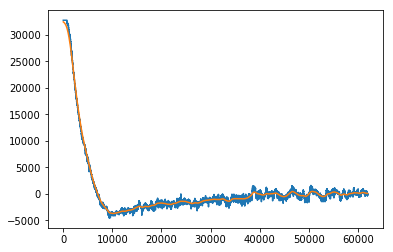

saving 0--62011
filtering 62011--162511


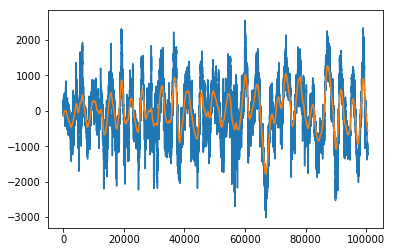

saving 62011--162011
filtering 161511--185327


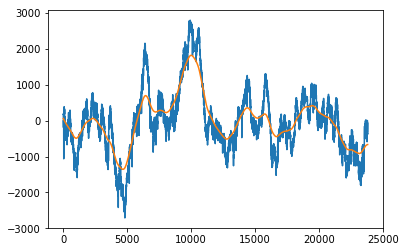

saving 162011--185327
<AnalogSignalArray at 0x21c09968320: 1 signals (2 segments)> for a total of 6.1776 seconds


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


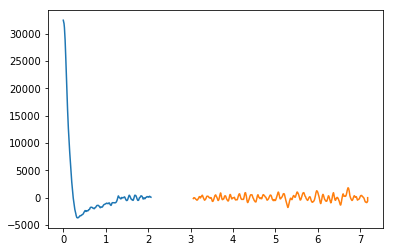

In [30]:


def butterfilt(finname, foutname, fmt, fs, fl=5.0, fh=100.0, gpass=1.0, gstop=30.0, ftype='butter', buffer_len=100000, overlap_len=100, max_len=-1):
    """Given sampling frequency, low and high pass frequencies design a butterworth filter, and filter our data with it."""
    fso2 = fs/2.0
    wp = [fl/fso2, fh/fso2]
    ws = [0.8*fl/fso2,1.4*fh/fso2]
    b, a = iirdesign(wp, ws, gpass=gpass, gstop=gstop, ftype=ftype, output='ba')
    y = filtfiltlong(finname, foutname, fmt, b, a, buffer_len, overlap_len, max_len)
    return y, b, a

def filtfiltlong(finname, foutname, fmt, b, a, buffer_len=100000, overlap_len=100, max_len=-1):
    """Use memmap and chunking to filter continuous data.
    Inputs:
    finname -
    foutname    -
    fmt         - data format eg 'i'
    b,a         - filter coefficients
    buffer_len  - how much data to process at a time
    overlap_len - how much data do we add to the end of each chunk to smooth out filter transients
    max_len     - how many samples to process. If set to -1, processes the whole file
    Outputs:
    y           - The memmapped array pointing to the written file
    Notes on algorithm:
    1. The arrays are memmapped, so we let pylab (numpy) take care of handling large arrays
    2. The filtering is done in chunks:
    Chunking details:
                |<------- b1 ------->||<------- b2 ------->|
    -----[------*--------------{-----*------]--------------*------}----------
            |<-------------- c1 -------------->|
                                |<-------------- c2 -------------->|
    From the array of data we cut out contiguous buffers (b1,b2,...) and to each buffer we add some extra overlap to
    make chunks (c1,c2). The overlap helps to remove the transients from the filtering which would otherwise appear at
    each buffer boundary.
    """
    x = memmap(finname, dtype=fmt, mode='r')
    if max_len == -1:
        max_len = x.size
    try:
        y = memmap(foutname, dtype=fmt, mode='w+', shape=max_len)
    except OSError:
        raise ValueError('Not sure why this ODError is raised, actually? File already exists?')
        

    ts = np.fromfile('timestamps.raw', dtype=np.uint32)
    epochs = jag.utils.get_contiguous_segments(ts)
    ccr = np.cumsum(epochs[:,1] - epochs[:,0]).astype(np.int32)
    filter_epochs = np.vstack((np.insert(ccr[:-1],0,0),ccr)).T

    for (start, stop) in filter_epochs:
#         print(start)
        
        for buff_st_idx in range(start, stop, buffer_len):
            chk_st_idx = max(start, buff_st_idx - overlap_len)
            buff_nd_idx = min(stop, buff_st_idx + buffer_len)
            chk_nd_idx = min(stop, buff_nd_idx + overlap_len)
            rel_st_idx = buff_st_idx - chk_st_idx
            rel_nd_idx = buff_nd_idx - chk_st_idx
            print('filtering {}--{}'.format(chk_st_idx, chk_nd_idx))
#             this_y_chk = filtfilt(b, a, x[chk_st_idx:chk_nd_idx], method="gust") # gust has nan infs error!?
            [b, a] = scipy.signal.butter(1, 10/(30000/2))
            this_y_chk = filtfilt(b, a, x[chk_st_idx:chk_nd_idx], padlen=150)
            plt.plot(x[chk_st_idx:chk_nd_idx])
            plt.plot(this_y_chk)
            plt.show()
            print('saving {}--{}'.format(buff_st_idx, buff_nd_idx))
            y[buff_st_idx:buff_nd_idx] = this_y_chk[rel_st_idx:rel_nd_idx]

    return y

y, b, a = butterfilt(finname='channels/gap_ch.02.raw', buffer_len=100000,
                     foutname='filtered.raw',
                     fmt=np.int16,
                     fs=30000,
                     fl=50,
                     fh=800,
                     overlap_len=500)

ts = np.fromfile('timestamps.raw', dtype=np.uint32)
y = np.fromfile('filtered.raw', dtype=np.int16)
sig = nel.AnalogSignalArray(ydata=y, timestamps=ts/30000, fs=30000)
print(sig)
npl.plot(sig)

<AnalogSignalArray at 0x21c050c84e0: 1 signals (2 segments)> for a total of 6.1776 seconds


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


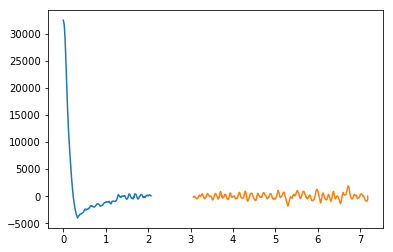

In [27]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
y = np.fromfile('filtered.raw', dtype=np.int16)
sig = nel.AnalogSignalArray(ydata=y, timestamps=ts/30000, fs=30000)
print(sig)
npl.plot(sig)

In [95]:
[b, a] = scipy.signal.butter(5, 600/(30000/2))

<AnalogSignalArray at 0x21c0505d7f0: 1 signals (2 segments)> for a total of 6.1776 seconds


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


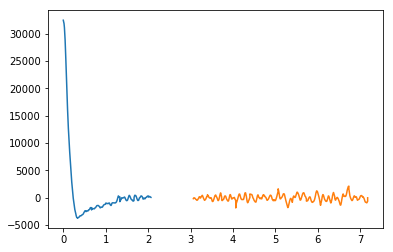

In [22]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
y = np.fromfile('filtered.raw', dtype=np.int16)
sig = nel.AnalogSignalArray(ydata=y, timestamps=ts/30000, fs=30000)
print(sig)
npl.plot(sig)

In [24]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [4]:
from scipy.signal import filtfilt, iirdesign
from numpy import memmap

def butterfilt(finname, foutname, fmt, fs, fl=5.0, fh=100.0, gpass=1.0, gstop=30.0, ftype='butter', buffer_len=100000, overlap_len=100, max_len=-1):
    """Given sampling frequency, low and high pass frequencies design a butterworth filter, and filter our data with it."""
    fso2 = fs/2.0
    wp = [fl/fso2, fh/fso2]
    ws = [0.8*fl/fso2,1.4*fh/fso2]
    b, a = iirdesign(wp, ws, gpass=gpass, gstop=gstop, ftype=ftype, output='ba')
    y = filtfiltlong(finname, foutname, fmt, b, a, buffer_len, overlap_len, max_len)
    return y, b, a

def filtfiltlong(finname, foutname, fmt, b, a, buffer_len=100000, overlap_len=100, max_len=-1):
    """Use memmap and chunking to filter continuous data.
    Inputs:
    finname -
    foutname    -
    fmt         - data format eg 'i'
    b,a         - filter coefficients
    buffer_len  - how much data to process at a time
    overlap_len - how much data do we add to the end of each chunk to smooth out filter transients
    max_len     - how many samples to process. If set to -1, processes the whole file
    Outputs:
    y           - The memmapped array pointing to the written file
    Notes on algorithm:
    1. The arrays are memmapped, so we let pylab (numpy) take care of handling large arrays
    2. The filtering is done in chunks:
    Chunking details:
                |<------- b1 ------->||<------- b2 ------->|
    -----[------*--------------{-----*------]--------------*------}----------
            |<-------------- c1 -------------->|
                                |<-------------- c2 -------------->|
    From the array of data we cut out contiguous buffers (b1,b2,...) and to each buffer we add some extra overlap to
    make chunks (c1,c2). The overlap helps to remove the transients from the filtering which would otherwise appear at
    each buffer boundary.
    """
    x = memmap(finname, dtype=fmt, mode='r')
    if max_len == -1:
        max_len = x.size
    y = memmap(foutname, dtype=fmt, mode='w+', shape=max_len)

    for buff_st_idx in range(0, max_len, buffer_len):
        chk_st_idx = max(0, buff_st_idx - overlap_len)
        buff_nd_idx = min(max_len, buff_st_idx + buffer_len)
        chk_nd_idx = min(x.size, buff_nd_idx + overlap_len)
        rel_st_idx = buff_st_idx - chk_st_idx
        rel_nd_idx = buff_nd_idx - chk_st_idx
        print('filtering {}--{}'.format(chk_st_idx, chk_nd_idx))
        print(x[chk_st_idx:chk_nd_idx])
        this_y_chk = filtfilt(b, a, x[chk_st_idx:chk_nd_idx], method="gust")
        print('saving {}--{}'.format(buff_st_idx, buff_nd_idx))
#         y[buff_st_idx:buff_nd_idx] = this_y_chk[rel_st_idx:rel_nd_idx]

    return y

y, b, a = butterfilt(finname='channels/gap_ch.02.raw', buffer_len=10000,
                     foutname='filtered.raw',
                     fmt=np.int16,
                     fs=30000,
                     fl=500,
                     fh=8000,
                     overlap_len=500)

plt.plot(x)
plt.plot(y)

filtering 0--10500
[32767 32767 32767 ..., -4027 -4058 -3931]


ValueError: array must not contain infs or NaNs

In [8]:
np.any(np.isinf(y))

False

In [3]:
file_list = ['../sample_data/sample_data_1.rec',
             '../sample_data/sample_data_3.rec',
             '../sample_data/sample_data_4.rec',
             '../sample_data/sample_data_5.rec',
             '../sample_data/sample_data_2.rec'
            ]

jfm = jag.io.JagularFileMap(file_list)

print(jfm)

<JagularFileMap: 5 files spanning 9:45:54:849 hours (missing 52:19:480 minutes between files)> at 0x1c1ed47c898


In [4]:
file_list = ['../sample_data/gap_data.rec']
jfm = jag.io.JagularFileMap(file_list)
print(jfm)

<JagularFileMap: 1 file spanning 7.1775 seconds> at 0x1c1ea1fa208


In [5]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)

In [6]:
print('Timestamps contain duplicates: {}'.format(jag.utils.has_duplicate_timestamps(timestamps=ts)))

dupes = jag.utils.get_duplicate_timestamps(timestamps=ts)
print(dupes)

Timestamps contain duplicates: False
[]


In [7]:
ts

array([     0,      1,      2, ..., 215323, 215324, 215325], dtype=uint32)

In [8]:
# search for missing data, and either interpolate, or split into epochs

# to filter:
# (1) find contiguous segments, identify sample boundaries
# (2) for each contiguous segment in the table, do the filtering independently

# this functionality should probably be (a) automatic when calling filtering, and (b) available explicitly as well

# assume timestamps are integral (uint32)
# assume timestamps are unsigned, positive?
# assume timestamps are in order
# assume no duplicate timestamps
# assume no missing timestamps


# NOTE: in-core vs out-of-core needs to be handled and tested with memmap
# NOTE: channels (and timestamps) are read in chunks, so we should do the
#       processing in chunks, and maybe later check for consistency in the
#       entire timestamps file. We therefore also need an overlap, since 
#       we may have to interpolate over two chunks of data! 

in_core = True
ts_dtype = np.uint32

# step 1: make sure that timestamps are integral, and the expected datatype:
if ts.dtype != ts_dtype:
    raise TypeError('timestamps are in an unexpected format: {} expected, but {} found!'.format(ts_dtype, ts.dtype))
# step 2: make sure that timestamps are ordered
if in_core:
    if not jag.utils.is_sorted(ts):
        ts = np.sort(ts) # this assumes in-core
else:
    raise NotImplementedError('out-of-core sorting has not been implemented yet')
# step 3: check for, and remove duplicate timestamps

# step 4: check for, and prepare for dealing with missing timestamps
    

gap_lengths = jag.utils.get_gap_lengths_from_timestamps(timestamps=ts, in_core=True)

In [9]:
ts = ts.astype(np.uint64)

In [10]:
jag.utils.is_sorted(ts)

True

In [11]:
ts

array([     0,      1,      2, ..., 215323, 215324, 215325], dtype=uint64)

In [12]:
len(np.argwhere(np.diff(ts) < 1))

0

In [13]:
ts[67268]
ts[67269]


97268

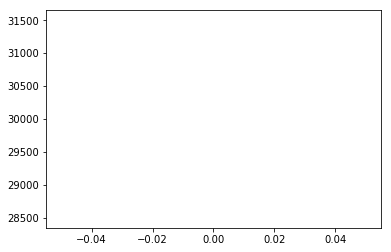

In [14]:
plt.plot(gap_lengths)

In [15]:
def linear_interp_gaps(gap=10)

SyntaxError: invalid syntax (<ipython-input-15-5283a05da4bc>, line 1)

In [16]:
cs = jag.utils.get_contiguous_segments(ts)

gap_lengths = cs[1:,0] - cs[:-1,1]


In [17]:
cs

array([[      0.,   62011.],
       [  92010.,  215326.]])

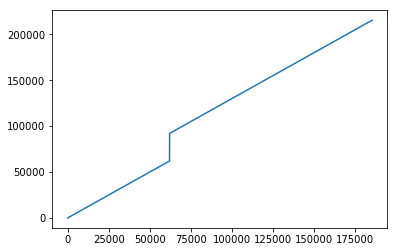

In [18]:
plt.plot(ts)

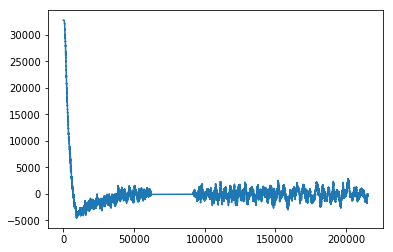

In [19]:
# load unfiltered data ASSUMING CONTINUOUS
x = np.fromfile('channels/gap_ch.02.raw', dtype=np.int16)
plt.plot(ts,x)

In [23]:
def is_integer(my_list):
    """
    my_list = [1,2,5,6, 9.0, '65'] # True, since all elements can be cast without loss to integers
    my_list = [1,2,5,6, 9.0, 'a'] # False, since 'a' is not an integer
    """
    try:
        return all(float(item).is_integer() for item in my_list)
    except ValueError:
        pass
    return False

In [21]:
my_list = [1,2,5,6, 9.0, '65']

is_integer(my_list)

True

In [23]:
max_gap_size = 200

ch_out_prefix = 'channels/gap_'
n_chan_zfill = len(str(jfm._reader.n_spike_channels))
ch_out_files = [ch_out_prefix + 'ch.' + str(n).zfill(n_chan_zfill) + '.raw' for n in range(jfm._reader.n_spike_channels)]

from contextlib import ExitStack
from scipy.interpolate import interp1d

prev_channel_data = None # used for across-block interpolation
prev_ts_data = None      # used for across-block interpolation
# assumption: block_size >> interp_size (we can check for this with an assert)

with ExitStack() as stack:
    ts_file = stack.enter_context(open('timestamps.raw', 'wb+'))
    ch_files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    for ii, (ts, all_ch_data) in enumerate(jfm.read_stitched_files(block_size=800)):
        # inspect timestamps, and interpolate if necessary...
        # TODO: add full sanitization here...
        
        if max_gap_size > 0:
                
            if prev_ts_data is not None: 
                inter_block_gap = ts[0] - prev_ts_data
                if (inter_block_gap <= max_gap_size) & (inter_block_gap > 1):
                    print('we need to interpolate across blocks! (block {} to {}, sample {} to {})'.format(ii-1, ii, prev_ts_data, ts[0]))
                    pre_ts = np.arange(prev_ts_data, ts[0])
                    f = interp1d([prev_ts_data, ts[0]], np.vstack([prev_channel_data, all_ch_data[:,0]]).T, assume_sorted=True)
                    pre_ch = f(pre_ts) # in floats, not np.int16!
                    pre_ch = pre_ch.astype(np.int16)
                    print(pre_ch.shape)
                    print(all_ch_data.shape)
                    all_ch_data = np.hstack([pre_ch, all_ch_data])
                    print(all_ch_data.shape)
                    ts = np.hstack([pre_ts, ts])
                    print(ts)

            prev_ts_data = ts[-1]
            prev_channel_data = all_ch_data[:,-1]

            # now interpolate all interior qualifying regions of the block:
            # get gaps
            cs = jag.utils.get_contiguous_segments(ts).astype(np.int32)
            gap_lengths = cs[1:,0] - cs[:-1,1]

            if np.any(gap_lengths <= max_gap_size):
                # only do this if there are some gaps satisfying the criteria
                tt = np.argwhere(gap_lengths<=max_gap_size)
                vv = np.argwhere(gap_lengths>max_gap_size)
                ccl = (np.cumsum(cs[:,1] - cs[:,0]) - 1).astype(np.int32)
                ccr = np.cumsum(cs[:,1] - cs[:,0]).astype(np.int32)
                orig_data_locs = np.vstack((np.insert(ccr[:-1],0,0),ccr)).T # want this as seperate function, too!
                split_data_ts = []
                split_data = []
                for kk, (start, stop) in enumerate(orig_data_locs):
                    split_data_ts.append(cs[kk,0])
                    split_data.append(all_ch_data[:,start:stop])
                stops = cs[:,1]
                starts = cs[1:,0]

                interpl_ts = np.atleast_1d(stops[tt].squeeze())
                interpl_ch = np.atleast_2d(all_ch_data[:,ccl[tt]])
                interpl_ch = interpl_ch.squeeze(axis=2)

                interpr_ts = np.atleast_1d(starts[tt].squeeze())
                interpr_ch = np.atleast_2d(all_ch_data[:,ccr[tt]])
                interpr_ch = interpr_ch.squeeze(axis=2)

                new_cs = np.hstack((np.vstack((cs[0,0], starts[vv])), np.vstack((stops[vv], cs[-1,1]))))

                # generate new timestamps:
                ts_list = [list((nn for nn in range(start, stop))) for (start, stop) in new_cs]
                ts_new = [item for sublist in ts_list for item in sublist]

                for kk, (itsl, itsr) in enumerate(zip(interpl_ts, interpr_ts)):
                    # build interp object
                    f = interp1d([itsl-1, itsr], np.vstack([interpl_ch[:,kk], interpr_ch[:,kk]]).T, assume_sorted=True)
                    interp_ts = np.arange(itsl, itsr)
                    interp_ch = f(interp_ts) # in floats, not np.int16!
                    interp_ch = interp_ch.astype(np.int16)
                    split_data_ts.append(itsl)
                    split_data.append(interp_ch)

                # now reassemble split channeldata chunks in order:
                chunk_order = np.argsort(split_data_ts)
                ch_data_new = np.hstack([split_data[hh] for hh in chunk_order])

                all_ch_data = ch_data_new
                ts = ts_new

        # re-estimate number of packets
        num_packets = len(ts)
        my_ch_struct = struct.Struct('<%dh' % num_packets)
        my_ts_struct = struct.Struct('<%dI' % num_packets)
        ts_packed = my_ts_struct.pack(*ts)
                
        for ch in range(jfm._reader.n_spike_channels):
            ch_packed = my_ch_struct.pack(*all_ch_data[ch,:])  
            # write current channel data of current block to file:
            ch_files[ch].write(ch_packed)
            
        # write timestamps of current block to file:
        ts_file.write(ts_packed)  

d:\dropbox\code\jagular\jagular\utils.py:116: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1c1fe087978: 1 signals (2 segments)> for a total of 6.1776 seconds


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:113: UserWarning: fs was not specified, so we try to estimate it from the data...
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:115: UserWarning: fs was estimated to be 30000.000000003303 Hz
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


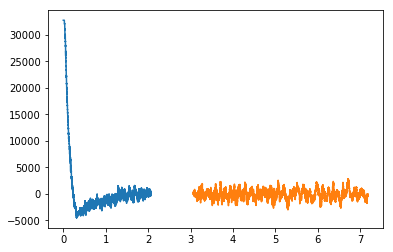

In [26]:
ts = np.fromfile('timestamps.raw', dtype=np.uint32)
y = np.fromfile('channels/gap_ch.02.raw', dtype=np.int16)
sig = nel.AnalogSignalArray(ydata=y, timestamps=ts/30000)
print(sig)
npl.plot(sig)

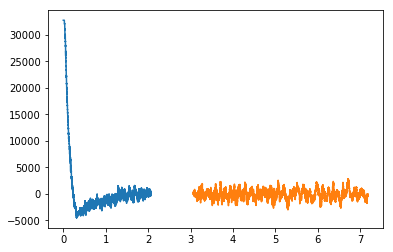

In [21]:
sig = nel.AnalogSignalArray(ydata=all_ch_data, timestamps=np.array(ts)/30000)

d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:113: UserWarning: fs was not specified, so we try to estimate it from the data...
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:115: UserWarning: fs was estimated to be 30000.000000003303 Hz
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:267: UserWarning: creating support from time and sampling rate, fs!


<AnalogSignalArray at 0x1c1edcb7f98: 80 signals (2 segments)> for a total of 6.1776 seconds


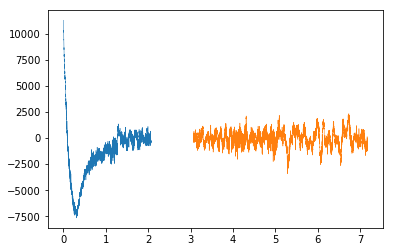

In [22]:
print(sig)
npl.plot(sig[:,1], lw=0.5)

<AnalogSignalArray at 0x242968e9ef0: 80 signals (51 segments)> for a total of 51.0 seconds


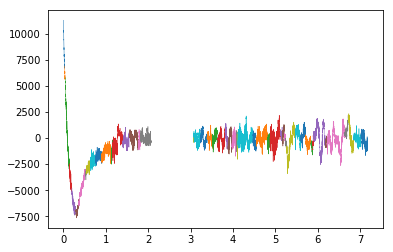

In [301]:
print(sig)
npl.plot(sig[:,1], lw=0.5)

False

In [244]:
gap_size = 90
# TODO:::
if np.any(gap_lengths <= gap_size):
    # only do this if there are some gaps satisfying the criteria
    tt = np.argwhere(gap_lengths<=gap_size)
    vv = np.argwhere(gap_lengths>gap_size)
    ccl = (np.cumsum(cs[:,1] - cs[:,0]) - 1).astype(np.int32)
    ccr = np.cumsum(cs[:,1] - cs[:,0]).astype(np.int32)
    orig_data_locs = np.vstack((np.insert(ccr[:-1],0,0),ccr)).T # want this as seperate function, too!
    split_data_ts = []
    split_data = []
    for kk, (start, stop) in enumerate(orig_data_locs):
        split_data_ts.append(cs[kk,0])
        split_data.append(all_ch_data[:,start:stop])
    stops = cs[:,1]
    starts = cs[1:,0]

    interpl_ts = np.atleast_1d(stops[tt].squeeze())
    interpl_ch = np.atleast_2d(all_ch_data[:,ccl[tt]])
    interpl_ch = interpl_ch.squeeze(axis=2)

    interpr_ts = np.atleast_1d(starts[tt].squeeze())
    interpr_ch = np.atleast_2d(all_ch_data[:,ccr[tt]])
    interpr_ch = interpr_ch.squeeze(axis=2)

    new_cs = np.hstack((np.vstack((cs[0,0], starts[vv])), np.vstack((stops[vv], cs[-1,1]))))

#     print(interpl_ts, '--', interpr_ts)
#     print('---------')
#     print(new_cs)

    # generate new timestamps:
    ts_list = [list((nn for nn in range(start, stop))) for (start, stop) in new_cs]
    ts_new = [item for sublist in ts_list for item in sublist]

    for kk, (itsl, itsr) in enumerate(zip(interpl_ts, interpr_ts)):
        # build interp object
#         print(itsl, itsr)
        f = interp1d([itsl-1, itsr], np.vstack([interpl_ch[:,kk], interpr_ch[:,kk]]).T, assume_sorted=True)
        interp_ts = np.arange(itsl, itsr)
        interp_ch = f(interp_ts) # in floats, not np.int16!
        interp_ch = interp_ch.astype(np.int16)
        split_data_ts.append(itsl)
        split_data.append(interp_ch)

    # now reassemble split channeldata chunks in order:
    chunk_order = np.argsort(split_data_ts)
    ch_data_new = np.hstack([split_data[hh] for hh in chunk_order])
else:
    ch_data_new = all_ch_data
    ts_new = ts

[] -- []
---------
[[ 800  806]
 [ 999 1198]
 [1385 1980]]


In [245]:
ch_data_new.shape

(80, 800)

In [221]:
np.hstack((split_data[1], split_data[1]))

array([[-11025, -11070, -11073, ...,  -9066,  -9104,  -9037],
       [  6910,   6824,   6778, ...,   5739,   5737,   5708],
       [ 32096,  32168,  32113, ...,  29912,  29864,  29854],
       ..., 
       [ 32767,  32767,  32767, ...,  32767,  32767,  32767],
       [  1945,   1980,   1962, ...,   1294,   1304,   1259],
       [ -1733,  -1666,  -1528, ...,   -640,   -730,   -906]], dtype=int16)

In [219]:
np.hstack((split_data[0][1], split_data[1][1]))

array([[-11167, -11096, -11122, ...,  -9066,  -9104,  -9037],
       [  6709,   6780,   6821, ...,   5739,   5737,   5708],
       [ 32157,  32107,  32045, ...,  29912,  29864,  29854],
       ..., 
       [ 32767,  32767,  32767, ...,  32767,  32767,  32767],
       [  2035,   1983,   2002, ...,   1294,   1304,   1259],
       [ -2034,  -2171,  -2203, ...,   -640,   -730,   -906]], dtype=int16)

In [211]:
chunk_order

array([0, 1, 3, 2], dtype=int64)

In [203]:
split_data

[(800, array([[-11167, -11096, -11122, -11049, -11072, -11025],
         [  6709,   6780,   6821,   6851,   6849,   6902],
         [ 32157,  32107,  32045,  32072,  32036,  32040],
         [ 31370,  31475,  31433,  31351,  31356,  31456],
         [ 28700,  28651,  28644,  28693,  28718,  28687],
         [ -7150,  -7105,  -7008,  -6989,  -6967,  -6927],
         [ 26322,  26328,  26293,  26327,  26369,  26366],
         [ 32767,  32767,  32767,  32767,  32767,  32767],
         [ 23504,  23575,  23571,  23487,  23481,  23477],
         [ 32767,  32767,  32767,  32767,  32767,  32767],
         [ 13166,  13210,  13243,  13168,  13073,  13046],
         [  8880,   8834,   8930,   8983,   8884,   8846],
         [  2440,   2507,   2512,   2464,   2463,   2483],
         [ 32767,  32767,  32767,  32767,  32767,  32767],
         [ -2331,  -2259,  -2284,  -2302,  -2415,  -2395],
         [  1772,   1765,   1775,   1790,   1790,   1732],
         [  3294,   3360,   3377,   3291,   3288,  

In [198]:
np.vstack([interpl_ch[:,kk], interpr_ch[:,kk]]).T

IndexError: too many indices for array

In [134]:
interpl_ts

array([1198])

In [85]:
ts[205]

1385

In [98]:
orig_data_locs = np.vstack((np.insert(ccr[:-1],0,0),ccr)).T
for start, stop in orig_data_locs:
    print(start, stop)

0 6
6 205
205 800


In [319]:
all_ch_data.shape

(80, 800)

In [328]:
ts_new

[800,
 801,
 802,
 803,
 804,
 805,
 999,
 1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1021,
 1022,
 1023,
 1024,
 1025,
 1026,
 1027,
 1028,
 1029,
 1030,
 1031,
 1032,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1048,
 1049,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1068,
 1069,
 1070,
 1071,
 1072,
 1073,
 1074,
 1075,
 1076,
 1077,
 1078,
 1079,
 1080,
 1081,
 1082,
 1083,
 1084,
 1085,
 1086,
 1087,
 1088,
 1089,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,

In [106]:
breaks = np.argwhere(np.diff(data)>=2*step)
starts = np.insert(breaks+1, 0, 0)
stops = np.append(breaks, len(data)-1)
bdries = np.vstack((data[starts], data[stops] + step)).T

TypeError: only integer arrays with one element can be converted to an index

In [97]:
import nelpy as nel

In [98]:
nel.utils.get_contiguous_segments(ts)

TypeError: only integer arrays with one element can be converted to an index

In [103]:
jag.utils.get_contiguous_segments(ts[:1], assume_sorted=True, in_core=True)

C:\Users\etien\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
C:\Users\etien\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
d:\dropbox\code\jagular\jagular\utils.py:120: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


array([[ 800.,   nan]])

In [82]:
gap_lengths = jag.utils.get_gap_lengths_from_timestamps(timestamps=ts, in_core=True)
len(gap_lengths)

TypeError: only integer arrays with one element can be converted to an index

In [7]:
ch_out_prefix = 'channels/gap_'
n_chan_zfill = len(str(jfm._reader.n_spike_channels))
ch_out_files = [ch_out_prefix + 'ch.' + str(n).zfill(n_chan_zfill) + '.raw' for n in range(jfm._reader.n_spike_channels)]
# print(ch_out_files)

In [8]:
#TODO: make filenames configurable
#TODO: warn if files already exist, or if we cannot create them (this latter one should be handled automatically)

from contextlib import ExitStack

with ExitStack() as stack:
    ts_file = stack.enter_context(open('timestamps.raw', 'wb+'))
    ch_files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    for ii, (ts, all_ch_data) in enumerate(jfm.read_stitched_files(block_size=4)):
        num_packets = len(ts)

        my_ts_struct = struct.Struct('<%dI' % num_packets)
        my_ch_struct = struct.Struct('<%dh' % num_packets)
        ts_packed = my_ts_struct.pack(*ts)
        for ch in range(jfm._reader.n_spike_channels):
            ch_packed = my_ch_struct.pack(*all_ch_data[ch,:])
            # write current channel data of current block to file:
            ch_files[ch].write(ch_packed)
            
        # write timestamps of current block to file:
        ts_file.write(ts_packed)       


In [39]:
# now try to read back some data:

ts_from_file = np.fromfile('timestamps.raw', dtype=np.uint32)

In [40]:
ts_from_file

array([    200917,   55205700,   55205701,   55205702,   55205703,
         55205704,   55205705,   55205706,   55205707,   55205708,
        190383308,  216003235,   45380179,   45380180,   45380181,
         45380182,   45380183,   45380184,   45380185,   45380186,
         45380187,  430419684,  428619684,   55912384,   55912385,
         55912386,   55912387,   55912388,   55912389,   55912390,
         55912391,   55912392,  617928812,  648279793,   23871545,
         23871546,   23871547,   23871548,   23871549,   23871550,
         23871551,   23871552,   23871553,  824383837,  864397337,
         23104817,   23104818,   23104819,   23104820,   23104821,
         23104822,   23104823,   23104824,   23104825, 1054846413], dtype=uint32)

In [47]:
for ii, (ts, ch_data) in enumerate(jfm.read_stitched_files(block_size=5)):
    print(ii, ts)

0 [200917, 55205700, 55205701, 55205702, 55205703]
1 [55205704, 55205705, 55205706, 55205707, 55205708]
2 [190383308, 216003235, 45380179, 45380180, 45380181]
3 [45380182, 45380183, 45380184, 45380185, 45380186]
4 [45380187, 430419684, 428619684, 55912384, 55912385]
5 [55912386, 55912387, 55912388, 55912389, 55912390]
6 [55912391, 55912392, 617928812, 648279793, 23871545]
7 [23871546, 23871547, 23871548, 23871549, 23871550]
8 [23871551, 23871552, 23871553, 824383837, 864397337]
9 [23104817, 23104818, 23104819, 23104820, 23104821]
10 [23104822, 23104823, 23104824, 23104825, 1054846413]


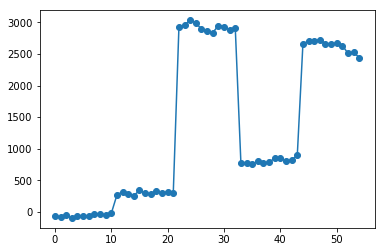

In [215]:
# load unfiltered data ASSUMING CONTINUOUS
fmt='<i'
x = np.fromfile('2017-05-31_16-11-39_ch.00.raw', dtype=np.int16)
plt.plot(x, marker='o')

In [ ]:
memmap()

In [125]:
from scipy.signal import filtfilt, iirdesign
from numpy import memmap

def butterfilt(finname, foutname, fmt, fs, fl=5.0, fh=100.0, gpass=1.0, gstop=30.0, ftype='butter', buffer_len=100000, overlap_len=100, max_len=-1):
    """Given sampling frequency, low and high pass frequencies design a butterworth filter, and filter our data with it."""
    fso2 = fs/2.0
    wp = [fl/fso2, fh/fso2]
    ws = [0.8*fl/fso2,1.4*fh/fso2]
    b, a = iirdesign(wp, ws, gpass=gpass, gstop=gstop, ftype=ftype, output='ba')
    y = filtfiltlong(finname, foutname, fmt, b, a, buffer_len, overlap_len, max_len)
    return y, b, a

def filtfiltlong(finname, foutname, fmt, b, a, buffer_len=100000, overlap_len=100, max_len=-1):
    """Use memmap and chunking to filter continuous data.
    Inputs:
    finname -
    foutname    -
    fmt         - data format eg 'i'
    b,a         - filter coefficients
    buffer_len  - how much data to process at a time
    overlap_len - how much data do we add to the end of each chunk to smooth out filter transients
    max_len     - how many samples to process. If set to -1, processes the whole file
    Outputs:
    y           - The memmapped array pointing to the written file
    Notes on algorithm:
    1. The arrays are memmapped, so we let pylab (numpy) take care of handling large arrays
    2. The filtering is done in chunks:
    Chunking details:
                |<------- b1 ------->||<------- b2 ------->|
    -----[------*--------------{-----*------]--------------*------}----------
            |<-------------- c1 -------------->|
                                |<-------------- c2 -------------->|
    From the array of data we cut out contiguous buffers (b1,b2,...) and to each buffer we add some extra overlap to
    make chunks (c1,c2). The overlap helps to remove the transients from the filtering which would otherwise appear at
    each buffer boundary.
    """
    x = memmap(finname, dtype=fmt, mode='r')
    if max_len == -1:
        max_len = x.size
    y = memmap(foutname, dtype=fmt, mode='w+', shape=max_len)

    for buff_st_idx in range(0, max_len, buffer_len):
        chk_st_idx = max(0, buff_st_idx - overlap_len)
        buff_nd_idx = min(max_len, buff_st_idx + buffer_len)
        chk_nd_idx = min(x.size, buff_nd_idx + overlap_len)
        rel_st_idx = buff_st_idx - chk_st_idx
        rel_nd_idx = buff_nd_idx - chk_st_idx
        print('filtering {}--{}'.format(chk_st_idx, chk_nd_idx))
        print('saving {}--{}'.format(buff_st_idx, buff_nd_idx))
        this_y_chk = filtfilt(b, a, x[chk_st_idx:chk_nd_idx], method="gust")
        y[buff_st_idx:buff_nd_idx] = this_y_chk[rel_st_idx:rel_nd_idx]

    return y

y, b, a = butterfilt(finname='2017-05-31_16-11-39_ch.00.raw', buffer_len=10,
                     foutname='filtered.raw',
                     fmt=np.int16,
                     fs=30000,
                     fl=500,
                     fh=8000,
                     overlap_len=5)

plt.plot(x)
plt.plot(y)

filtering 0--15
saving 0--10
filtering 5--25
saving 10--20
filtering 15--35
saving 20--30
filtering 25--45
saving 30--40
filtering 35--55
saving 40--50
filtering 45--55
saving 50--55


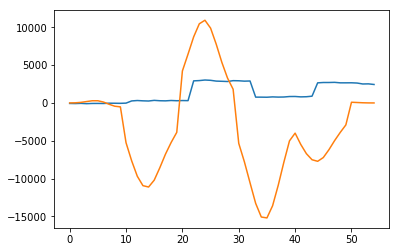

In [214]:
y, b, a = butterfilt(finname='2017-05-31_16-11-39_ch.00.raw', buffer_len=10,
                     foutname='filtered.raw',
                     fmt=np.int16,
                     fs=30000,
                     fl=500,
                     fh=8000,
                     overlap_len=5)

plt.plot(x)
plt.plot(y)

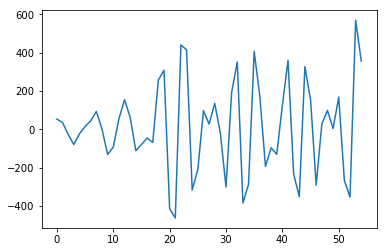

In [146]:
tim

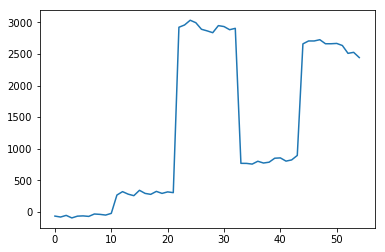

In [78]:
y = memmap('2017-05-31_16-11-39_ch.00.raw', dtype=np.int16)
plt.plot(y)

In [ ]:
# AllDataArr = np.memmap('',dtype=np.int16,shape=(n_samples,n_ch_dat),mode='r')
# b,a = signal.butter(3,100./(SAMPLE_RATE/2),'high') #filter at 100 Hz
# IntraArr = AllDataArr[:,IntraChannel].copy()
# IntraArr = signal.filtfilt(b,a,IntraArr)
# Thresh = IntraArr.max()*THRESH_FRAC

In [45]:
import struct

ch = 5

ch_data = all_ch_data[ch,:]  # get a 1-D array of numbers
arrSize = len(ch_data)

my_struct = struct.Struct('<%dh' % arrSize)

# packed = struct.pack('<iiHHi%df' % arrSize,
#     nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

In [ ]:
flattened = npVect.ravel()  # get a 1-D array of numbers
arrSize = len(flattened)
# pack header, count of numbers, and numbers, all in one call
packed = struct.pack('<iiHHi%df' % arrSize,
    nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

In [16]:
from contextlib import ExitStack

with ExitStack() as stack:
    files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    
    flattened = npVect.ravel()  # get a 1-D array of numbers
arrSize = len(flattened)
# pack header, count of numbers, and numbers, all in one call
packed = struct.pack('<iiHHi%df' % arrSize,
    nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

['ch.0000.raw',
 'ch.0001.raw',
 'ch.0002.raw',
 'ch.0003.raw',
 'ch.0004.raw',
 'ch.0005.raw',
 'ch.0006.raw',
 'ch.0007.raw',
 'ch.0008.raw',
 'ch.0009.raw',
 'ch.0010.raw',
 'ch.0011.raw',
 'ch.0012.raw',
 'ch.0013.raw',
 'ch.0014.raw',
 'ch.0015.raw',
 'ch.0016.raw',
 'ch.0017.raw',
 'ch.0018.raw',
 'ch.0019.raw',
 'ch.0020.raw',
 'ch.0021.raw',
 'ch.0022.raw',
 'ch.0023.raw',
 'ch.0024.raw',
 'ch.0025.raw',
 'ch.0026.raw',
 'ch.0027.raw',
 'ch.0028.raw',
 'ch.0029.raw',
 'ch.0030.raw',
 'ch.0031.raw',
 'ch.0032.raw',
 'ch.0033.raw',
 'ch.0034.raw',
 'ch.0035.raw',
 'ch.0036.raw',
 'ch.0037.raw',
 'ch.0038.raw',
 'ch.0039.raw',
 'ch.0040.raw',
 'ch.0041.raw',
 'ch.0042.raw',
 'ch.0043.raw',
 'ch.0044.raw',
 'ch.0045.raw',
 'ch.0046.raw',
 'ch.0047.raw',
 'ch.0048.raw',
 'ch.0049.raw',
 'ch.0050.raw',
 'ch.0051.raw',
 'ch.0052.raw',
 'ch.0053.raw',
 'ch.0054.raw',
 'ch.0055.raw',
 'ch.0056.raw',
 'ch.0057.raw',
 'ch.0058.raw',
 'ch.0059.raw',
 'ch.0060.raw',
 'ch.0061.raw',
 'ch.006

In [6]:

for ii, (ts, ch_data) in enumerate(jfm.read_stitched_files(block_size=5)):
    print(ii, ts)

0 [200917, 55205700, 55205701, 55205702, 55205703]
1 [55205704, 55205705, 55205706, 55205707, 55205708]
2 [190383308, 216003235, 45380179, 45380180, 45380181]
3 [45380182, 45380183, 45380184, 45380185, 45380186]
4 [45380187, 430419684, 428619684, 55912384, 55912385]
5 [55912386, 55912387, 55912388, 55912389, 55912390]
6 [55912391, 55912392, 617928812, 648279793, 23871545]
7 [23871546, 23871547, 23871548, 23871549, 23871550]
8 [23871551, 23871552, 23871553, 824383837, 864397337]
9 [23104817, 23104818, 23104819, 23104820, 23104821]
10 [23104822, 23104823, 23104824, 23104825, 1054846413]


In [28]:
jag.io.JagularFileMap('../sample_data/sample_data_1.rec')

<JagularFileMap: 1 files spanning 1:45:39:413 hours (missing 0.0 milliseconds)> at 0x1f92107c278

In [29]:
jfm.timestamps

array([[  6.69723333e+00,   6.34611027e+03],
       [  7.20010783e+03,   1.43473228e+04],
       [  1.42873228e+04,   2.05976271e+04],
       [  2.16093264e+04,   2.74794612e+04],
       [  2.88132446e+04,   3.51615471e+04]])

In [30]:
jfm.timesamples

array([[    200917,  190383308],
       [ 216003235,  430419684],
       [ 428619684,  617928812],
       [ 648279793,  824383837],
       [ 864397337, 1054846413]])

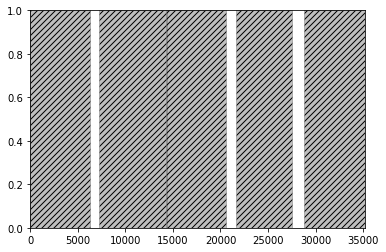

In [31]:
ax = jfm.plot()
# ax.set_xlim(0, 300);

In [32]:
jfm._samples_within_bounds(2853122, 7093204 )

True

In [33]:
jfm._time_within_bounds(100, 250)

True

In [34]:
print("duration including gaps: {}".format(jfm.duration_w_gaps))
print("duration excluding gaps: {}".format(jfm.duration_wo_gaps))

duration including gaps: 9:45:54:849 hours
duration excluding gaps: 8:53:35:369 hours


In [83]:
from contextlib import ExitStack

with open('test1', 'w') as f:
    f.write('f1b1f1b2f1b3f1b4')
    
with open('test2', 'w') as f:
    f.write('f2b1f2b2f2b3f2b4')
    
with open('test3', 'w') as f:
    f.write('f3b1f3b2')
    
with open('test4', 'w') as f:
    f.write('f4b1f4b2f4b3f4b4f4b5')
    
filenames = ['test1', 'test2', 'test3', 'test4']

from contextlib import ExitStack

def read_stitched_files(nch=2):
    with ExitStack() as stack:
        files = [stack.enter_context(open(fname, 'r')) for fname in filenames]
        ii=0
        while True:
            try:
                chunk = files[ii].read(4*nch)
                if 0 < len(chunk) < 4*nch:
                    # chunk size could not be filled from current file, so move onto next file
                    ii+=1
                    chunkB = files[ii].read(4*int(nch-len(chunk)/4))
                    chunk = chunk + chunkB
                if chunk:
                    yield chunk
                else:
                    ii+=1
            except IndexError:
                return
                       
for chunk in read_stitched_files(3):
    print(chunk)

f1b1f1b2f1b3
f1b4f2b1f2b2
f2b3f2b4f3b1
f3b2f4b1f4b2
f4b3f4b4f4b5


In [82]:
with open('test1', 'w') as f:
    f.write('f1b1f1b2f1b3f1b4')
with open('test2', 'w') as f:
    f.write('f2b1f2b2f2b3f2b4')
with open('test3', 'w') as f:
    f.write('f3b1f3b2')   
with open('test4', 'w') as f:
    f.write('f4b1f4b2f4b3f4b4f4b5')

print('')
print('One symbol at a time:')
print('=======================')
for chunk in read_stitched_files(1):
    print(chunk)
    
print('')
print('Two symbols at a time:')
print('=======================')
for chunk in read_stitched_files(2):
    print(chunk)
    
print('')
print('Three symbols at a time:')
print('=======================')
for chunk in read_stitched_files(3):
    print(chunk)
    
print('')
print('Four symbols at a time:')
print('=======================')
for chunk in read_stitched_files(4):
    print(chunk)
    
print('')
print('Five symbols at a time:')
print('=======================')
for chunk in read_stitched_files(5):
    print(chunk)
    
print('')
print('Six symbols at a time:')
print('=======================')
for chunk in read_stitched_files(6):
    print(chunk)


One symbol at a time:
f1b1
f1b2
f1b3
f1b4
f2b1
f2b2
f2b3
f2b4
f3b1
f3b2
f4b1
f4b2
f4b3
f4b4
f4b5

Two symbols at a time:
f1b1f1b2
f1b3f1b4
f2b1f2b2
f2b3f2b4
f3b1f3b2
f4b1f4b2
f4b3f4b4

Three symbols at a time:
f1b1f1b2f1b3
f1b4f2b1f2b2
f2b3f2b4f3b1
f3b2f4b1f4b2
f4b3f4b4f4b5

Four symbols at a time:
f1b1f1b2f1b3f1b4
f2b1f2b2f2b3f2b4
f3b1f3b2f4b1f4b2

Five symbols at a time:
f1b1f1b2f1b3f1b4f2b1
f2b2f2b3f2b4f3b1f3b2
f4b1f4b2f4b3f4b4f4b5

Six symbols at a time:
f1b1f1b2f1b3f1b4f2b1f2b2
f2b3f2b4f3b1f3b2
